In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from my_modules.inthei import *

### image analysis

In [2]:
pics = np.linspace(1,9e3,9e3)
location = r'\Alta\30\253\Imagem '
ROI = (0,792,6,68)

In [3]:
iarray = im_start(pics,path=location,box=ROI)

In [4]:
iarray_b = bg_removal(iarray)
iarray_b.shape

(9000, 792, 62)

(-0.5, 61.5, 791.5, -0.5)

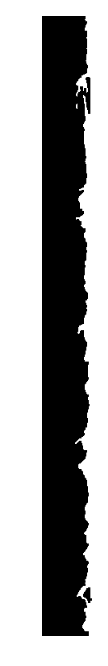

In [5]:
plt.figure(figsize=(4,8))
plt.imshow(im_proc(iarray_b[490]),cmap=plt.cm.gray)
plt.axis('off')

In [6]:
iarray_p = np.array([im_proc(i) for i in iarray_b])
iarray_p.shape, type(iarray_p)

((9000, 792, 62), numpy.ndarray)

In [7]:
iarray_h = [interface_height(ii,62) for ii in iarray_p]

In [8]:
gr = '#333333'
a1,a2 = interface_height(iarray_p[0],62)

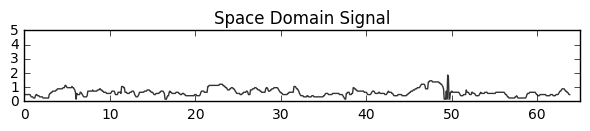

In [9]:
#with plt.rc_context({'axes.edgecolor':gr, 'xtick.color':gr,
#                     'ytick.color':gr, 'figure.facecolor':'white'}):
plt.figure(figsize=(6,2/np.sqrt(2)))
plt.plot(5*np.arange(0,792,1)/62,5-5*np.flipud(np.array(a2))/62,
         color=gr)
#plt.xlabel('Distance (mm)')
#plt.ylabel('Height (mm)')
plt.title('Space Domain Signal')
plt.axis([0,65,0,5])
plt.tight_layout()

In [267]:
h1 = np.zeros((iarray_p.shape[0],iarray_p.shape[1]))
for j,ii in enumerate(iarray_p):
    iarray_D, iarray_h = interface_height(ii,62)
    h1[j] = iarray_h

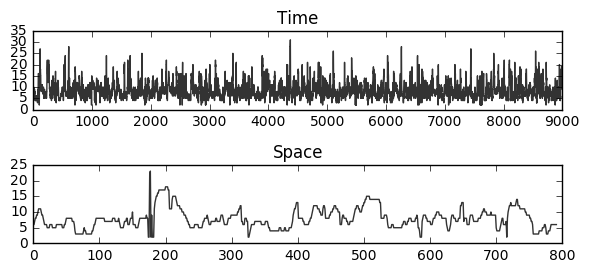

In [11]:
fig = plt.figure(figsize=(6,4/np.sqrt(2)))
ax1 = fig.add_subplot(211)
ax1.plot(62-h1[:,0],color=gr)
ax1.set_title('Time')
ax2 = fig.add_subplot(212)
ax2.plot(62-h1[0,:],color=gr)
ax2.set_title('Space')
plt.tight_layout()

### signal processing

<class 'numpy.ndarray'>
df = 0.33 Hz


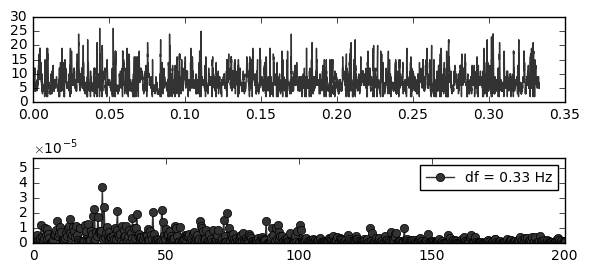

In [12]:
print(type(h1[:,0]))
sig = 62-h1[:,791]
fs = 3000
t = np.linspace(0,1000/fs,len(sig))
Y = np.fft.fft(sig - np.mean(sig),norm='ortho')
Y = 2 * Y / len(Y)
Y[0] = Y[0] / 2
f = np.fft.fftfreq(len(Y),d=1/fs)

fig = plt.figure(figsize=(6,4/np.sqrt(2)))
ax1 = fig.add_subplot(211)
ax1.plot(t,sig,color=gr)
ax2 = fig.add_subplot(212)
ax2.plot(f[0:int(len(Y)/2)],np.abs(Y[0:int(len(Y)/2)])**2,'o-',
        color=gr,label='df = {:.2f} Hz'.format(f[1]-f[0]))
ax2.set_xlim([0, 200])
ax2.set_ylim([0, 1.5*np.max(np.abs(Y[0:int(len(Y)/2)])**2)])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,4))
ax2.yaxis.major.formatter._useMathText = True
ax2.legend(loc='best',numpoints=1,fontsize=10)
plt.tight_layout()
print('df = {:.2f} Hz'.format(f[1]-f[0]))

In [13]:
#plt.figure(figsize=(8,2/np.sqrt(2)))
#plt.plot(np.correlate(sig,sig,mode='full'),'k')

In [14]:
idx = np.argmax(np.abs(Y[0:int(len(Y)/2)])**2)
print('Dominant frequency: {:.2f} Hz\nFrequency array index: {}'.format(f[idx],idx))

Dominant frequency: 26.00 Hz
Frequency array index: 78


In [15]:
fs = 3000
freq = []
for i,ts in enumerate(h1.T):
    ts_flip = np.mean(ts) - ts
    Y = np.fft.fft(ts_flip,norm='ortho')
    Y = 2 * Y / len(Y)
    Y[0] = Y[0] / 2
    f = np.fft.fftfreq(len(Y),d=1/fs)
    idx = np.argmax(np.abs(Y[0:int(len(Y)/2)])**2)
    freq.append(f[idx])
print('Frequência média: {:.2f} Hz'.format(np.mean(freq)))

Frequência média: 27.70 Hz


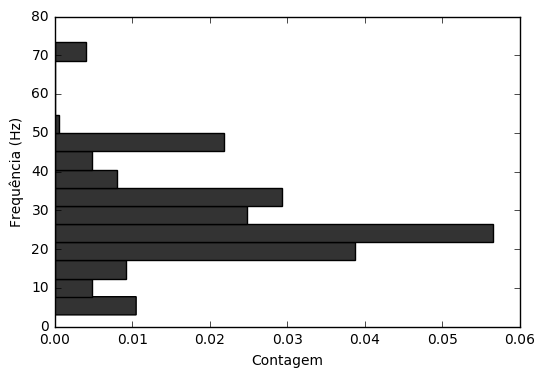

In [16]:
plt.hist(freq,bins=15,orientation='horizontal',
         histtype='bar',color=gr,normed=True)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Contagem')

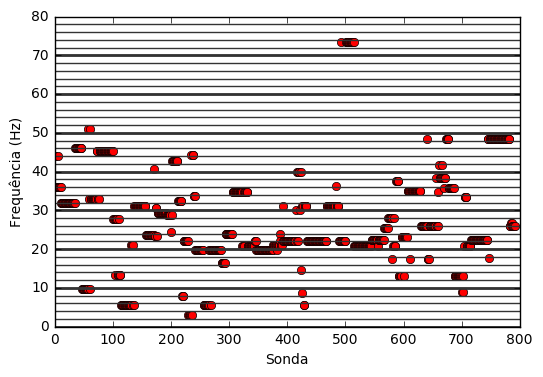

In [17]:
x_ax = [0, 800]
plt.plot(freq,'or')
for k in np.arange(0,80,2):
    plt.plot(x_ax,[k,k],'-',color=gr)
    if k % 10 == 0:
        plt.plot(x_ax,[k,k],'-',color=gr,linewidth=2)
plt.ylabel('Frequência (Hz)')
plt.xlabel('Sonda')

[6, 51, 27, 77, 245, 82, 147, 41, 18, 81, 2, 0, 0, 0, 15] 
soma = 792


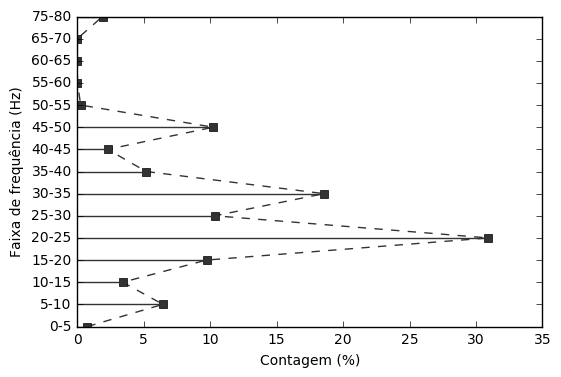

In [18]:
mi = [0]*15
for ff in freq:
    for i,div in enumerate(np.arange(5,81,5)):
        if ff <= div and ff > div-5:
            mi[i] += 1
print(mi,'\nsoma = {}'.format(sum(mi)))
fig, ax = plt.subplots()
ax.plot(np.array(mi)/7.92,list(range(15)),'s--',color=gr)
for i,m in enumerate(mi):
    ax.plot([0,m/7.92],[i,i],'-',color=gr)
ax.set_yticks(list(range(15)))
ax.set_yticklabels(['0-5','5-10','10-15','15-20',
                    '20-25','25-30','30-35','35-40',
                   '40-45','45-50','50-55','55-60',
                   '60-65','65-70','75-80'],rotation=0)
ax.set_ylabel('Faixa de frequência (Hz)')
ax.set_xlabel('Contagem (%)')

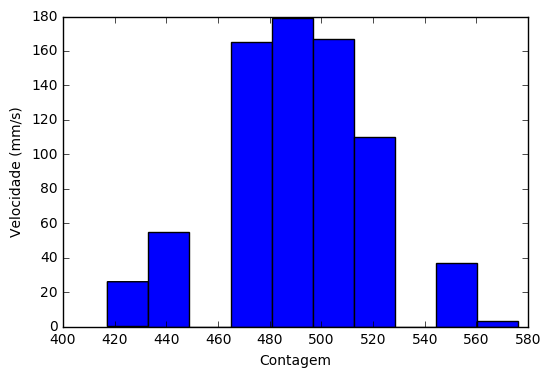

In [308]:
from scipy.signal import correlate
b = []
for i in range(np.shape(h1.T)[0]-50):
    b.append(np.argmax(correlate(5*(62-h1.T[i,:9000])/62,5*(62-h1.T[i+50,:9000])/62,mode='same')))
plt.hist(50 / (np.array(b) - 4500) * 5 / 62 * fs)
plt.ylabel('Velocidade (mm/s)')
plt.xlabel('Contagem')

489.637070974


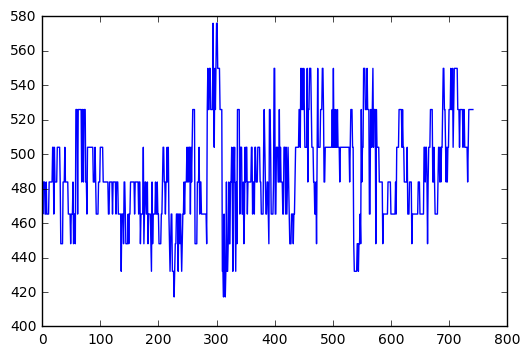

In [310]:
plt.plot(50 / (np.array(b) - 4500) * (5 / 62) * fs)
print(np.mean(50 / (np.array(b) - 4500) * (5 / 62) * fs))

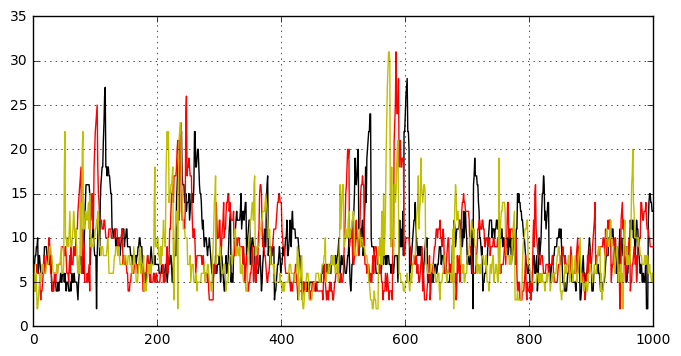

In [311]:
plt.figure(figsize=(8,4))
plt.plot(62-h1.T[0,:1000],'k')
plt.plot(62-h1.T[30,:1000],'r')
plt.plot(62-h1.T[60][:1000],'y')
plt.grid('on')

#import pandas as pd
#df = pd.DataFrame(h1.T[0],h1.T[600])
#df[0].to_csv('x')

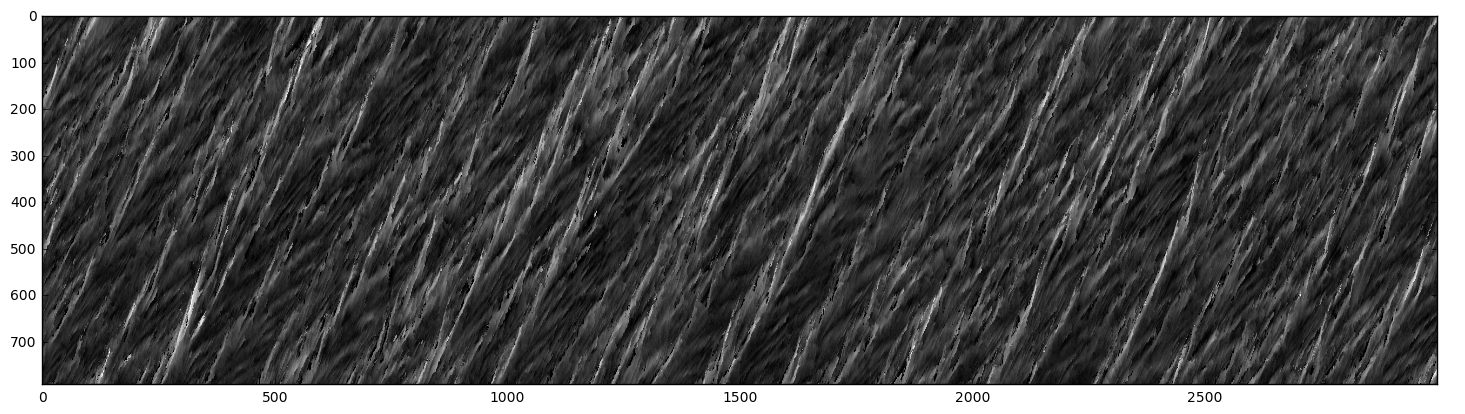

In [305]:
plt.figure(figsize=(18,12))
plt.imshow(5 * (62-h1.T[:,:3000]) / 62,cmap=plt.cm.gray)